# 넷플릭스 영화 데이터 분석

## 데이터 구조 살펴보기

In [46]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [47]:
from matplotlib import font_manager, rc

plt.rc("font", family="AppleGothic")

In [48]:
netflix_data = pd.read_csv("./data/NetflixOriginals.csv", encoding = 'latin-1')

In [49]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       584 non-null    object 
 1   Genre       584 non-null    object 
 2   Premiere    584 non-null    object 
 3   Runtime     584 non-null    int64  
 4   IMDB Score  584 non-null    float64
 5   Language    584 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 27.5+ KB


## 연속형 데이터 통계보기

#### IMDB Score는 평균 6.27점 정도

In [50]:
netflix_data.describe()

,Runtime,IMDB Score
count,584.000000,584.000000
mean,93.577055,6.271747
std,27.761683,0.979256
min,4.000000,2.500000
25%,86.000000,5.700000
50%,97.000000,6.350000
75%,108.000000,7.000000
max,209.000000,9.000000


## 카테고리형 통계 보기

In [51]:
netflix_data.describe(include = 'object')

,Title,Genre,Premiere,Language
count,584,584,584,584
unique,584,115,390,38
top,Enter the Anime,Documentary,"October 2, 2020",English
freq,1,159,6,401


## 데이터 전처리
language를 분리하여 분석합니다.

In [52]:
language_df = netflix_data.copy()

In [53]:
language_df['Language'] = language_df['Language'].str.split('/')

In [54]:
language_df = language_df.explode('Language')

In [55]:
language_df['Language'] = language_df['Language'].str.strip()

In [56]:
sorted_language_df = language_df['Language'].value_counts().index

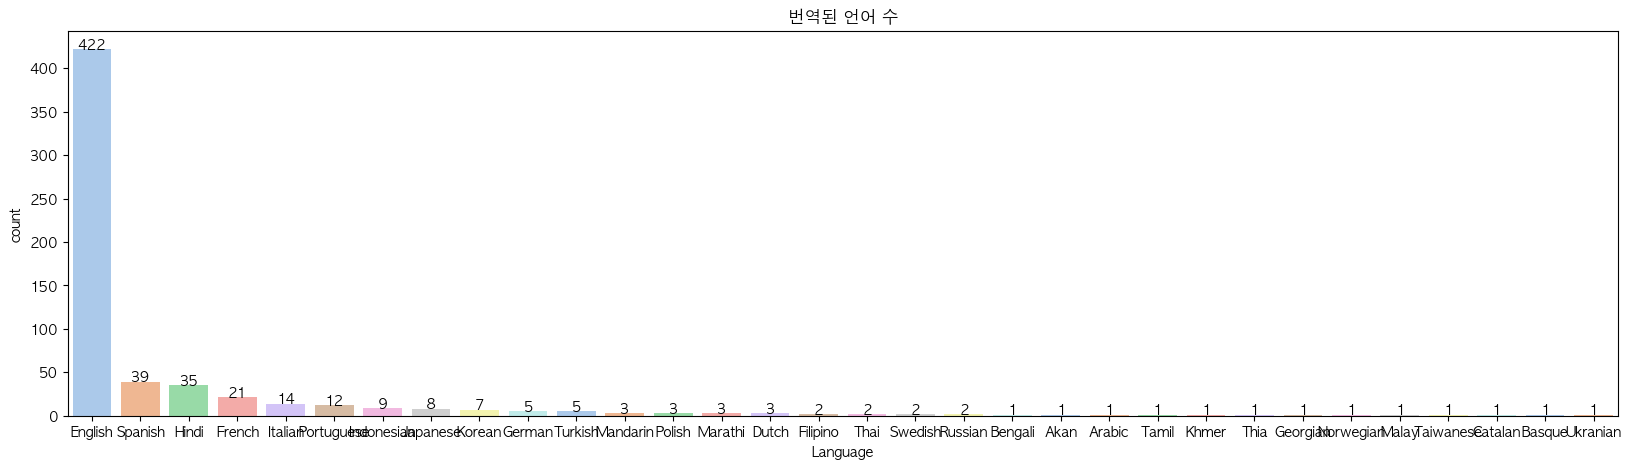

In [57]:
plt.figure(figsize=(20,5))
ax=sns.countplot(
    x='Language',
    data=language_df,
    order=sorted_language_df,
    palette="pastel"
)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            '{:1.0f}'.format(height),
            ha="center")

plt.title('번역된 언어 수')
plt.show()

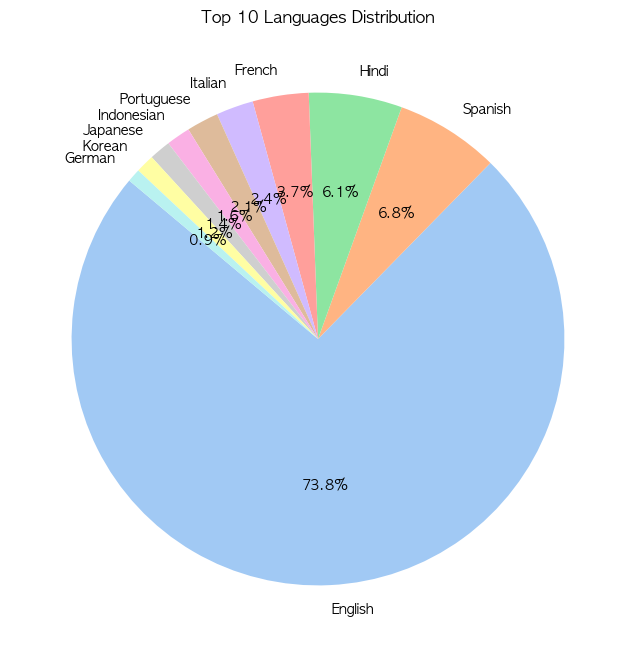

In [58]:
top_languages = language_df['Language'].value_counts().nlargest(10)

# 파이 차트를 그립니다.
plt.figure(figsize=(8, 8))
plt.pie(top_languages, labels=top_languages.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))

plt.title('Top 10 Languages Distribution')
plt.show()

In [59]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 폰트 캐시 삭제

# 시스템에서 NanumGothic 폰트 경로 찾기
nanum_font_path = '/Users/ayounglee/Downloads/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'

# 폰트 등록
fm.fontManager.addfont(nanum_font_path)
nanum_font = fm.FontProperties(fname=nanum_font_path).get_name()

# 폰트 설정
plt.rcParams['font.family'] = nanum_font
plt.rcParams['axes.unicode_minus'] = False  # ASCII 마이너스 기호 사용

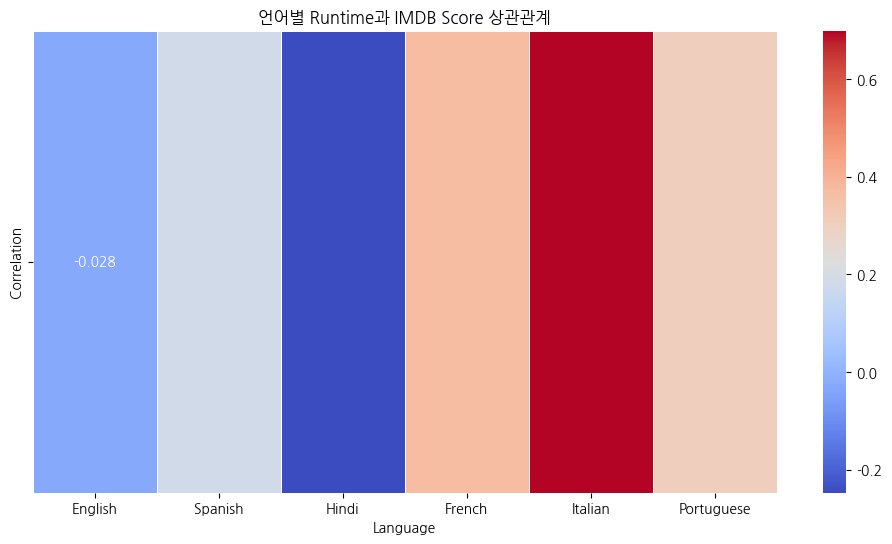

In [60]:
# Filter out languages with less than two entries
language_counts = language_df['Language'].value_counts()
valid_languages = language_counts[language_counts > 10].index

# Create a new dataframe to store the correlation for each valid language
valid_language_correlation_list = []

# Iterate over each valid language
for language in valid_languages:
    # Filter the dataframe for the current language
    language_filtered_df = language_df[language_df['Language'] == language]
    
    # Calculate the correlation matrix for the current language
    correlation = language_filtered_df[['Runtime', 'IMDB Score']].corr().iloc[0, 1]
    
    # Append the result to the list
    valid_language_correlation_list.append({'Language': language, 'Correlation': correlation})

# Create a dataframe from the list
valid_language_correlation_df = pd.DataFrame(valid_language_correlation_list)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(valid_language_correlation_df.set_index('Language').T, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('언어별 Runtime과 IMDB Score 상관관계')
plt.show()


In [61]:
valid_language_correlation_df

,Language,Correlation
0,English,-0.027821
1,Spanish,0.182534
2,Hindi,-0.247249
3,French,0.368437
4,Italian,0.698646
5,Portuguese,0.306710


## 데이터 전처리
Premiere의 데이터 형식을 바꿔줍니다.

In [62]:
netflix_data['Premiere_datetime'] = pd.to_datetime(netflix_data['Premiere'],errors='coerce')

In [63]:
netflix_data['Premiere_datetime'].isnull().sum()

5

#### Premiere 데이터를 변환후 결측치 채우기

In [64]:
nan_rows = netflix_data[netflix_data['Premiere_datetime'].isna()][['Title','Premiere']]
print(nan_rows)

                                     Title            Premiere
111                   Ghosts of Sugar Land    October 16. 2019
308                          Strong Island  September 15. 2017
387       Tony Robbins: I Am Not Your Guru       July 15. 2016
538  Joan Didion: The Center Will Not Hold    October 27. 2017
541                      The White Helmets  September 16. 2016


In [65]:
nan_rows_title = netflix_data[netflix_data['Premiere_datetime'].isna()]['Title']
print(nan_rows_title)

111                     Ghosts of Sugar Land
308                            Strong Island
387         Tony Robbins: I Am Not Your Guru
538    Joan Didion: The Center Will Not Hold
541                        The White Helmets
Name: Title, dtype: object


In [66]:
nan_rows_title_copy = nan_rows_title.copy()

In [67]:
netflix_data.loc[netflix_data['Premiere_datetime'].isna(), 'Premiere_datetime'] = [
    pd.Timestamp('2019-10-16'),
    pd.Timestamp('2017-09-15'),
    pd.Timestamp('2016-07-15'),
    pd.Timestamp('2017-10-27'),
    pd.Timestamp('2016-09-16')]

#### 맞게 채워졌는지 확인

In [68]:
netflix_data[netflix_data['Title'].isin(nan_rows_title_copy)][['Title', 'Premiere', 'Premiere_datetime']]

,Title,Premiere,Premiere_datetime
111,Ghosts of Sugar Land,October 16. 2019,2019-10-16
308,Strong Island,September 15. 2017,2017-09-15
387,Tony Robbins: I Am Not Your Guru,July 15. 2016,2016-07-15
538,Joan Didion: The Center Will Not Hold,October 27. 2017,2017-10-27
541,The White Helmets,September 16. 2016,2016-09-16


In [69]:
netflix_data["Premiere_datetime"].sort_values()

304   2014-12-13
519   2015-05-22
228   2015-05-29
550   2015-06-26
531   2015-07-17
         ...    
194   2021-05-21
245   2021-05-26
71    2021-05-26
275   2021-05-26
369   2021-05-27
Name: Premiere_datetime, Length: 584, dtype: datetime64[ns]

## EDA

### 연도별 개봉한 영화 수

In [70]:
year_movie_count = netflix_data['Premiere_datetime'].dt.year.value_counts().sort_index()

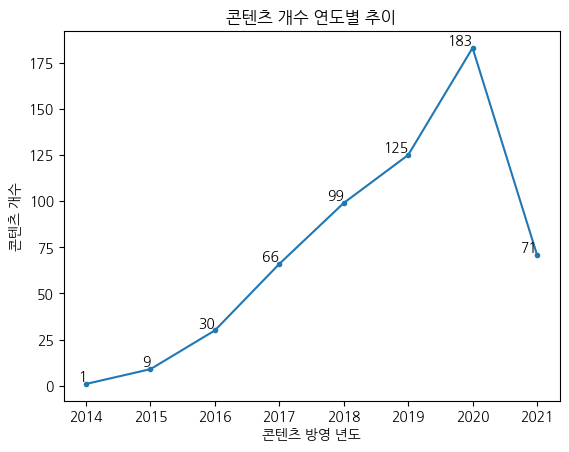

In [71]:
year_movie_count.plot(marker ='o', markersize = 3)
plt.xlabel("콘텐츠 방영 년도")
plt.ylabel("콘텐츠 개수")
plt.title("콘텐츠 개수 연도별 추이")

for x, y in zip(year_movie_count.index, year_movie_count.values):
    plt.text(x, y, str(y), ha="right", va="bottom")


#### 2014년도 12월부터 2021년도 5월까지 데이터에 포함된 것으로 보아 그 부분만 제외하면 매해 개봉되는 영화 수는 증가하고 있습니다.

### 년도별 평균 IMDB 평균 평점

In [72]:
year_score = netflix_data.groupby(netflix_data['Premiere_datetime'].dt.year)['IMDB Score'].mean()

In [73]:
year_score_rounded = year_score.round(2)

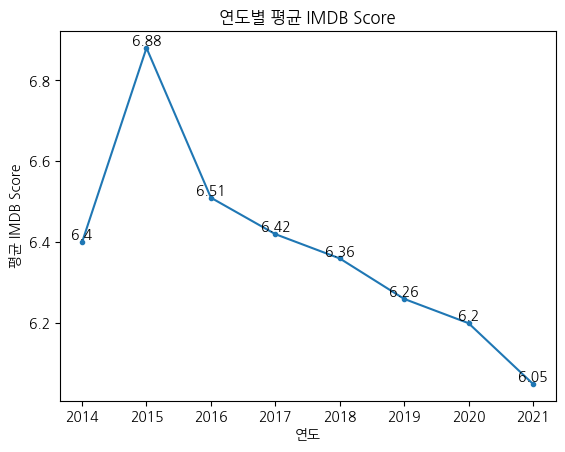

In [74]:
year_score_rounded.plot(marker = 'o', markersize = 3)
plt.xlabel("연도")
plt.ylabel("평균 IMDB Score")
plt.title("연도별 평균 IMDB Score")

for x, y in zip(year_score_rounded.index,year_score_rounded.values):
    plt.text(x,y,str(y),ha="center",va="bottom")

#### 2014년도 영화가 1개, 2015년도 9개 영화가 개봉되어 표본의 수가 작음에도 불구하고 2016년도부터 꾸준히 평균 IMDB Score평점이 하락세입니다. 

### 장르별 IMDB Score평균 점수를 보겠습니다


#### 장르과 여러개가 결합되어 있어서 분리를 해줍니다.
 다른 칼럼들도 늘어나기에 따로 카피해주고 분리해줍니다.

In [75]:
genre_df = netflix_data.copy()

In [76]:
genre_df['Genre'] = genre_df['Genre'].str.split('/')

In [77]:
genre_df = genre_df.explode('Genre')

In [78]:
genre_df['Genre'] = genre_df['Genre'].str.strip()

In [79]:
genre_count_df = genre_df['Genre'].value_counts()

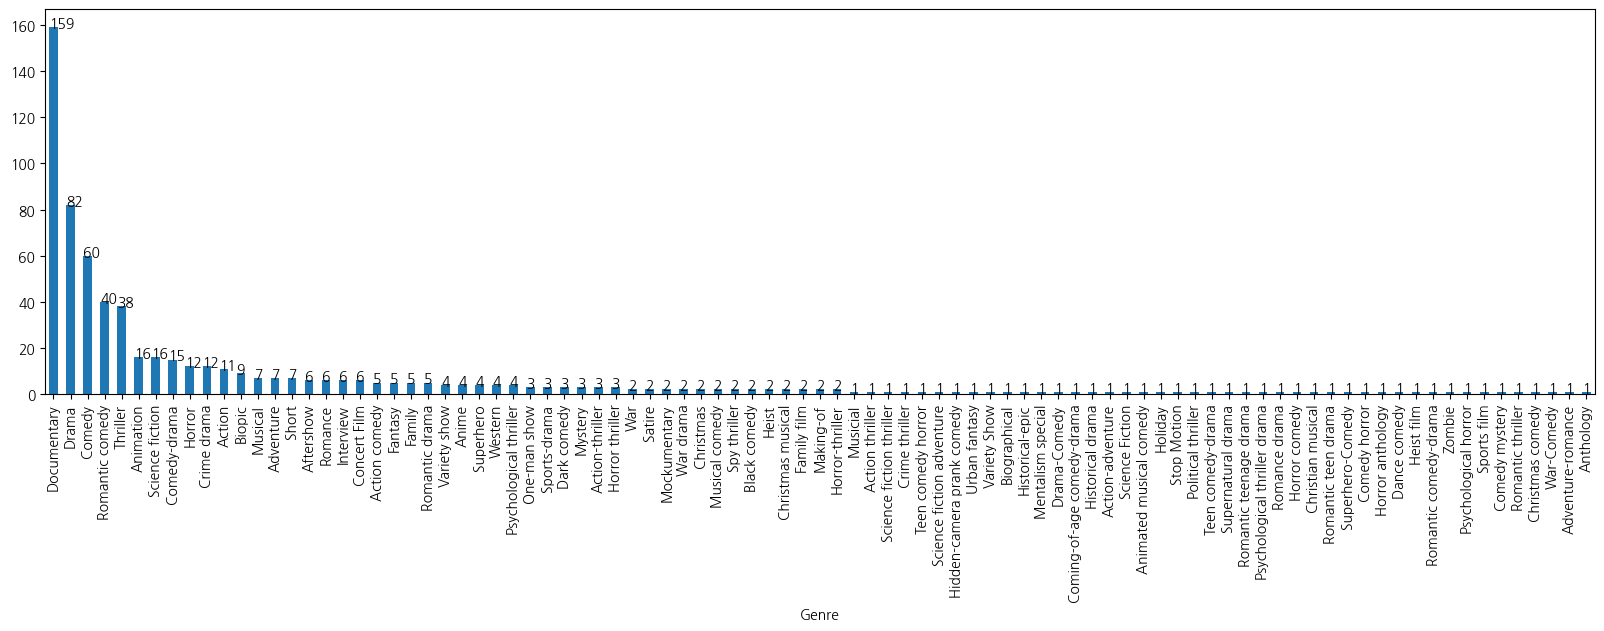

In [80]:
plt.figure(figsize=(20,5))
ax = genre_count_df.plot(kind="bar")

for p in ax.patches:
    ax.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

plt.show()

In [81]:
genre_df['Genre'].describe()

count             643
unique             91
top       Documentary
freq              159
Name: Genre, dtype: object

#### 장르가 1개인 것들도 있고 유니크한 값이 98개이므로 원활한 데이터 분석을 위해 비슷한 장르끼리 묶어서 분석합니다.

In [82]:
Genre_category = {
    'Thriller/Mystery': [
        'Thriller', 
        'Horror thriller', 
        'Horror', 
        'Political thriller', 
        'Horror anthology', 
        'Action-thriller', 
        'Psychological thriller drama', 
        'Horror comedy', 
        'Comedy horror', 
        'Psychological thriller', 
        'Zombie', 
        'Psychological horror', 
        'Romantic thriller', 
        'Horror-thriller', 
        'Crime thriller', 
        'Teen comedy horror', 
        'Action thriller', 
        'Science fiction thriller', 
        'Spy thriller',
        'Mystery',
        'Comedy mystery'
    ],
    'Drama': [
        'Drama',
        'Romance drama',
        'Teen comedy-drama',
        'Romantic drama',
        'Comedy-drama',
        'Supernatural drama',
        'Romantic teenage drama',
        'Crime drama',
        'Psychological thriller drama',
        'Romantic teen drama',
        'Romantic comedy-drama',
        'Sports-drama',
        'Dance comedy',
        'War drama',
        'Drama-Comedy',
        'Coming-of-age comedy-drama',
        'Historical drama',
        'Sports-drama',
        'Sports film'

    ],
    'Comedy': [
        'Comedy',
        'Romantic comedy',
        'Superhero-Comedy',
        'Action comedy',
        'Teen comedy-drama',
        'Comedy-drama',
        'Black comedy',
        'Horror comedy',
        'Dark comedy',
        'Comedy horror',
        'Mockumentary',
        'Romantic comedy-drama',
        'Comedy mystery',
        'Christmas comedy',
        'War-Comedy',
        'Holiday',
        'Teen comedy horror',
        'Musical comedy',
        'Hidden-camera prank comedy',
        'Animated musical comedy',
        'Drama-Comedy',
        'Coming-of-age comedy-drama',
        'Satire'
    ],
    'Romance': [
        'Romantic comedy',
        'Romance drama',
        'Romantic drama',
        'Romantic teenage drama',
        'Romance',
        'Romantic teen drama',
        'Romantic comedy-drama',
        'Romantic thriller',
        'Adventure-romance'
    ],   
    "Action/war/adventure": [
        "Action comedy",
        "Action",
        "Action-thriller",
        "War-Comedy",
        "War",
        "Action thriller",
        "War drama",
        "Spy thriller",
        "Action-adventure",
        "Western",
        "Adventure",
        "Adventure-romance",
        "Action-adventure"
    ],
    "Biopic/history": [
        "Biopic",
        "Biographical",
        "Historical-epic",
        "Historical drama",
        "Western"
    ],
    "Musical/concert/dance": [
        "Musical",
        "Christmas musical",
        "Christian musical",
        "Musical comedy",
        "Musicial",
        "Animated musical comedy",
        "Concert Film",
        "Dance comedy"
    ],
    'Science Fiction': [
        'Science fiction',
        'Science fiction adventure',
        'Science fiction thriller',
        'Science Fiction'
    ],
    "Christmas/Family/animation": [
        "Christmas musical",
        "Christmas comedy",
        "Christmas",
        "Family film",
        "Family",
        "Anime",
        "Animation",
        "Stop Motion",
        "Animated musical comedy"
    ],
    "Fantasy/Superhero": [
        "Fantasy",
        "Urban fantasy",
        "Superhero-Comedy",
        "Superhero"
    ],
    'Crime': [
        'Heist film',
        'Heist',
        'Crime drama',
        'Crime thriller'
    ],
    'Aftershow/interview': [
        'Aftershow',
        'Interview',
        'Making-of'
    ],
    "Short/Anthology": [
        "Short",
        "Anthology"
    ],
    "show program": [
        "Variety show",
        "One-man show",
        "Variety Show",
        "Mentalism special"
    ],
    "Documentary":[
        "Documentary"]
}



In [83]:
genre_df

,Title,Genre,Premiere,Runtime,IMDB Score,Language,Premiere_datetime
0,Enter the Anime,Documentary,"August 5, 2019",58,2.5,English/Japanese,2019-08-05
1,Dark Forces,Thriller,"August 21, 2020",81,2.6,Spanish,2020-08-21
2,The App,Science fiction,"December 26, 2019",79,2.6,Italian,2019-12-26
2,The App,Drama,"December 26, 2019",79,2.6,Italian,2019-12-26
3,The Open House,Horror thriller,"January 19, 2018",94,3.2,English,2018-01-19
...,...,...,...,...,...,...,...
579,Taylor Swift: Reputation Stadium Tour,Concert Film,"December 31, 2018",125,8.4,English,2018-12-31
580,Winter on Fire: Ukraine's Fight for Freedom,Documentary,"October 9, 2015",91,8.4,English/Ukranian/Russian,2015-10-09
581,Springsteen on Broadway,One-man show,"December 16, 2018",153,8.5,English,2018-12-16
582,Emicida: AmarElo - It's All For Yesterday,Documentary,"December 8, 2020",89,8.6,Portuguese,2020-12-08


In [84]:
category_genre_list = []
for category, genres in Genre_category.items():
    rows = genre_df[genre_df['Genre'].isin(genres)]
    for _, row in rows.iterrows():
        category_genre_list.append({
            'Category': category,
            'Title': row['Title'],
            'Genre': row['Genre'],
            'Premiere': row['Premiere'],
            'Runtime': row['Runtime'],
            'IMDB Score': row['IMDB Score'],
            'Language': row['Language'],
            'Premiere_datetime': row['Premiere_datetime']
        })

category_genre_df = pd.DataFrame(category_genre_list)

In [85]:
category_genre_df

,Category,Title,Genre,Premiere,Runtime,IMDB Score,Language,Premiere_datetime
0,Thriller/Mystery,Dark Forces,Thriller,"August 21, 2020",81,2.6,Spanish,2020-08-21
1,Thriller/Mystery,The Open House,Horror thriller,"January 19, 2018",94,3.2,English,2018-01-19
2,Thriller/Mystery,Kaali Khuhi,Mystery,"October 30, 2020",90,3.4,Hindi,2020-10-30
3,Thriller/Mystery,The Last Days of American Crime,Thriller,"June 5, 2020",149,3.7,English,2020-06-05
4,Thriller/Mystery,Mercy,Thriller,"November 22, 2016",90,4.2,English,2016-11-22
...,...,...,...,...,...,...,...,...
755,Documentary,Cuba and the Cameraman,Documentary,"November 24, 2017",114,8.3,English,2017-11-24
756,Documentary,Dancing with the Birds,Documentary,"October 23, 2019",51,8.3,English,2019-10-23
757,Documentary,Winter on Fire: Ukraine's Fight for Freedom,Documentary,"October 9, 2015",91,8.4,English/Ukranian/Russian,2015-10-09
758,Documentary,Emicida: AmarElo - It's All For Yesterday,Documentary,"December 8, 2020",89,8.6,Portuguese,2020-12-08


### 각 장르 카테고리별 평균 IMDB Score

In [86]:
category_score = category_genre_df.groupby('Category')['IMDB Score'].mean().sort_values(ascending = False)

In [87]:
category_score_rounded = category_score.round(2)

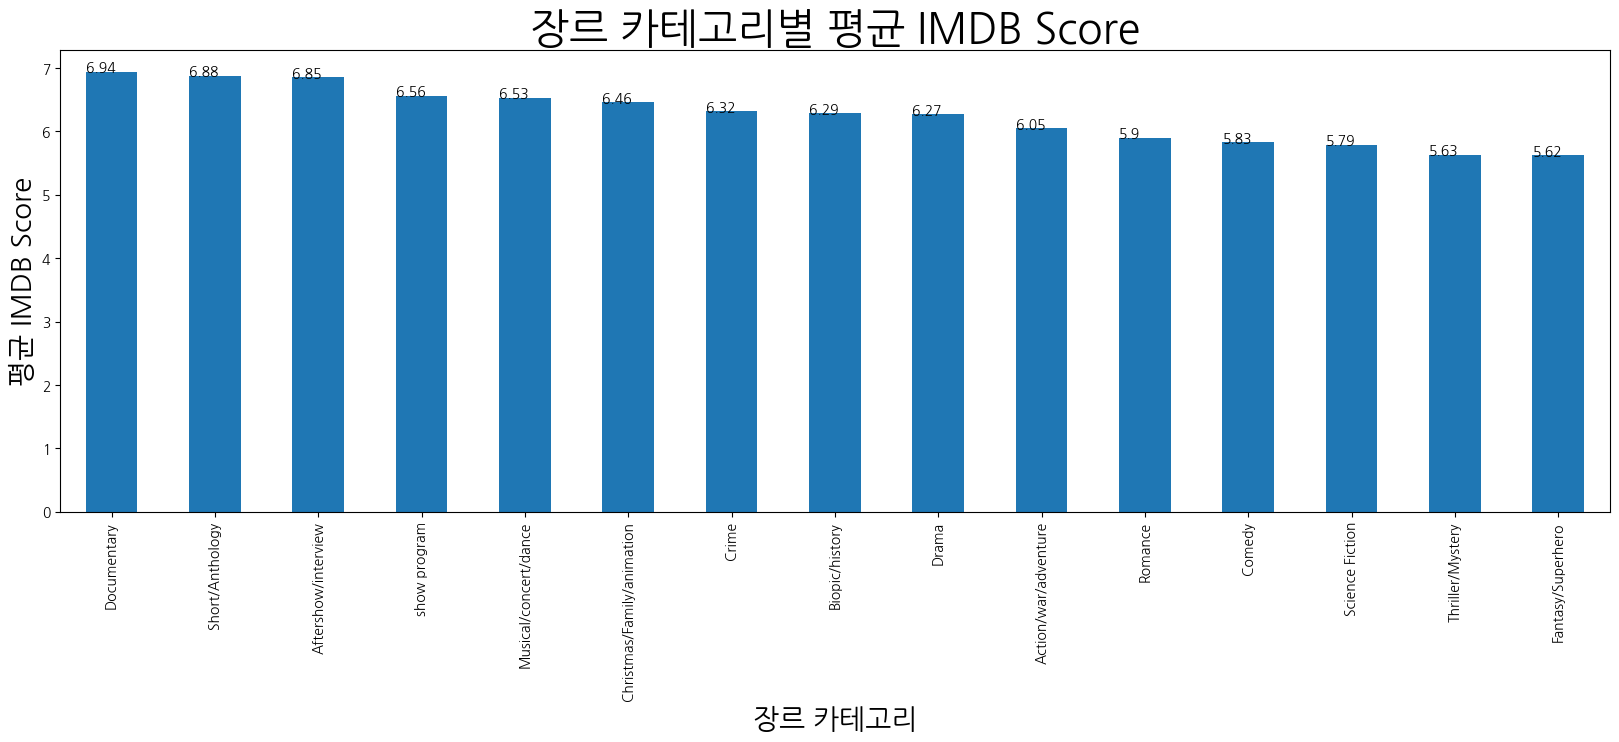

In [88]:
plt.figure(figsize=(20,6))
ax = category_score_rounded.plot(kind = "bar")
plt.xlabel("장르 카테고리",fontsize = 20)
plt.ylabel("평균 IMDB Score",fontsize = 20)
plt.title("장르 카테고리별 평균 IMDB Score",fontsize = 30)

for p in ax.patches:
    ax.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

### Documetary가 다른 장르와 비교했을 때 유의미하게 평균 IMDB Score평점이 다른지 비교합니다

In [89]:
from scipy import stats

In [90]:
Documentary_genre_scores =  category_genre_df[category_genre_df['Category'] == 'Documentary']['IMDB Score']
other_genre_scores = category_genre_df[category_genre_df['Category'] != 'Documentary']['IMDB Score']

In [91]:
statistics, p_value = stats.levene(Documentary_genre_scores,other_genre_scores)

In [92]:
statistics, p_value

(6.610287329690692, 0.010328780891820535)

#### 등분산 가정을 만족합니다.

In [93]:
t_statistics, p_value = stats.ttest_ind(
    a = Documentary_genre_scores,
    b = other_genre_scores,
    alternative = "two-sided",
    equal_var = True)

In [94]:
t_statistics, p_value

(11.140920982574256, 8.394648124906746e-27)

#### 귀무가설을 기각하지 못해 다큐멘터리의 평균 IMDB Score평점이 다른 장르 카테고리랑 다르지 않다라는 결론이 나왔습니다

### 각 장르 카테고리별 Runtime과 IMDB상관관계(heatmap)

In [95]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 폰트 캐시 삭제

# 시스템에서 NanumGothic 폰트 경로 찾기
nanum_font_path = '/Users/ayounglee/Downloads/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'

# 폰트 등록
fm.fontManager.addfont(nanum_font_path)
nanum_font = fm.FontProperties(fname=nanum_font_path).get_name()

# 폰트 설정
plt.rcParams['font.family'] = nanum_font
plt.rcParams['axes.unicode_minus'] = False  # ASCII 마이너스 기호 사용

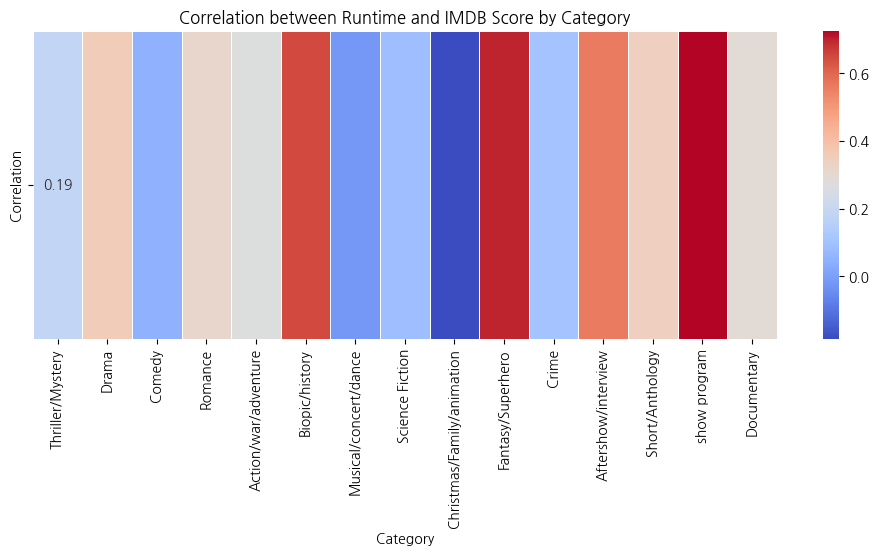

In [96]:
# Create a new dataframe to store the correlation for each category
category_correlation_list = []

# Iterate over each category
for category in category_genre_df['Category'].unique():
    # Filter the dataframe for the current category
    category_df = category_genre_df[category_genre_df['Category'] == category]
    
    # Calculate the correlation matrix for the current category
    correlation = category_df[['Runtime', 'IMDB Score']].corr().iloc[0, 1]
    
    # Append the result to the list
    category_correlation_list.append({'Category': category, 'Correlation': correlation})

# Create a dataframe from the list
category_correlation_df = pd.DataFrame(category_correlation_list)

# Plot the heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(category_correlation_df.set_index('Category').T, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation between Runtime and IMDB Score by Category')
plt.show()


In [97]:
category_correlation_df

,Category,Correlation
0,Thriller/Mystery,0.185753
1,Drama,0.357820
2,Comedy,0.051647
3,Romance,0.310214
4,Action/war/adventure,0.266752
5,Biopic/history,0.649227
6,Musical/concert/dance,-0.019851
7,Science Fiction,0.088661
8,Christmas/Family/animation,-0.185165
9,Fantasy/Superhero,0.699756


In [98]:
romance_df = category_genre_df[category_genre_df['Category']=='Romance']

#### Biopic/history,Fantasy/Superhero,Aftershow/interview,show program 의 Runtime이 길수록 IMDB Score점수가 높았습니다.

In [99]:
category_count = category_genre_df['Category'].value_counts()

In [100]:
category_count

Category
Documentary                   159
Comedy                        145
Drama                         131
Thriller/Mystery               80
Romance                        57
Action/war/adventure           40
Christmas/Family/animation     34
Musical/concert/dance          21
Science Fiction                19
Biopic/history                 16
Crime                          16
Aftershow/interview            14
Fantasy/Superhero              11
show program                    9
Short/Anthology                 8
Name: count, dtype: int64